# Classifying pulmonary diseases using chest X rays - CNN 

<b>Contact info</b>
<br>
<b>Name:</b> Mardja Bueno, Ph.D.
<br>
<b>email:</b> mardja.bueno@gmail.com
<br>

## 1. Overview and goals

## 2. The dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image
from pathlib import Path
import os

In [2]:
# create path for the folders where the training, test and validation images are
train_folders = 'Chest X ray images/train/' 
test_folders = 'Chest X ray images/test/'
val_folders = 'Chest X ray images/val/'

# create empty lists for train, test and val
total_train = {}
total_test = {}
total_val = {}

# iterate through the length of the list
for folder in os.listdir(train_folders):
    if not folder.startswith('.'): # so it doesn't open the .DS Store folder on Mac
        total_train[folder] = len(os.listdir(train_folders + folder))
    
for folder in os.listdir(test_folders):
    if not folder.startswith('.'):
        total_test[folder] = len(os.listdir(test_folders + folder))
    
for folder in os.listdir(val_folders):
    if not folder.startswith('.'):
        total_val[folder] = len(os.listdir(val_folders + folder))

# sum the number of images in each list
quantity_train = pd.DataFrame(list(total_train.items()), index = range(0,len(total_train)), columns = ['class','count'])
quantity_test = pd.DataFrame(list(total_test.items()), index = range(0,len(total_test)), columns = ['class','count'])
quantity_val = pd.DataFrame(list(total_val.items()), index = range(0,len(total_val)), columns = ['class','count'])

# print how many images we have in each dataset
print("Number of images in the training dataset : ", sum(total_train.values()))
print("Number of images in the testing dataset : ",sum(total_test.values()))
print("Number of images in the validation dataset : ",sum(total_val.values()))

Number of images in the training dataset :  6326
Number of images in the testing dataset :  771
Number of images in the validation dataset :  38


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Normal/Pneumonia/Covid-19/Tuberculosis). A total of 7135 x-ray images are present.

## 3. Exploratory data analysis

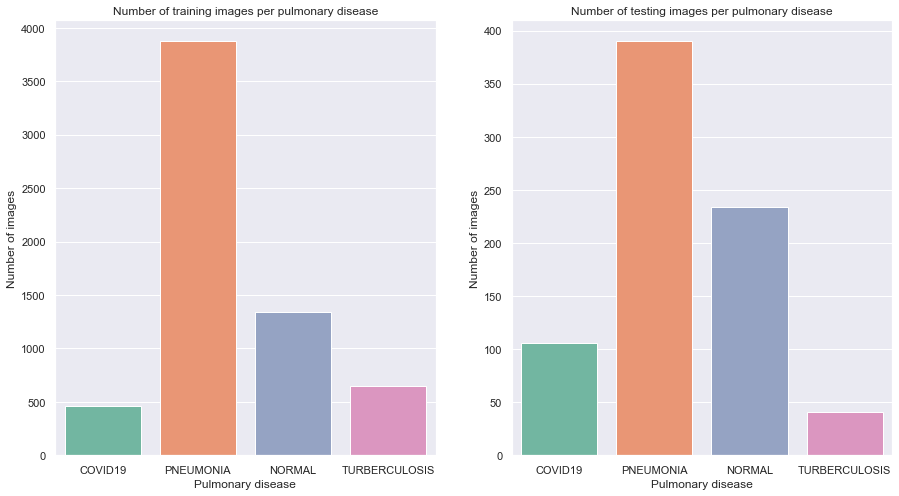

In [3]:
# create bar plots with the number of training and testing
# images in each folder per pulmonary disease
figure, ax = plt.subplots(1,2, figsize = (15,8))

sns.set_palette("Set2")

sns.barplot(x = 'class',y = 'count',data = quantity_train,ax = ax[0])
sns.barplot(x = 'class',y = 'count',data = quantity_test,ax = ax[1])


# set titles and labels
ax[0].set_title('Number of training images per pulmonary disease')
ax[0].set(xlabel = 'Pulmonary disease', ylabel = 'Number of images')

ax[1].set_title('Number of testing images per pulmonary disease')
ax[1].set(xlabel = 'Pulmonary disease', ylabel = 'Number of images')

plt.show()

In [4]:
# load images with the Keras API
from tensorflow.keras.utils import load_img, img_to_array

def sample_image(sample_image_path):
    img = load_img(sample_image_path)
    print((img_to_array(img)).shape)
    plt.imshow(img)
    plt.show()

(1294, 1168, 3)


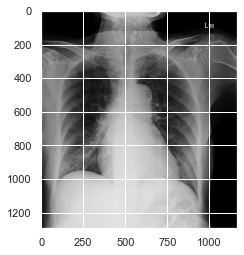

In [5]:
sample_image_path = train_folders+"/COVID19/COVID19(22).jpg"
sample_image(sample_image_path)

(1430, 1762, 3)


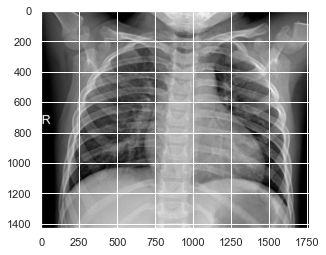

In [6]:
sample_image_path = train_folders+"/NORMAL/IM-0162-0001.jpeg"
sample_image(sample_image_path)

(1056, 1248, 3)


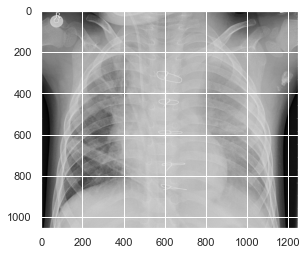

In [7]:
sample_image_path = train_folders+"/PNEUMONIA/person3_bacteria_10.jpeg"
sample_image(sample_image_path)

(512, 512, 3)


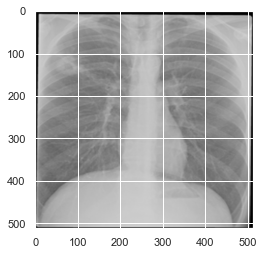

In [8]:
sample_image_path = train_folders+"/TURBERCULOSIS/Tuberculosis-12.png"
sample_image(sample_image_path)

## 4. Data preprocessing

In [9]:
# use tensorflow for the data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# use ImageDataGenerator to rescale and horizontally flip the images
train_image_gen = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip = True, 
                                     validation_split=0.2)

test_image_gen  = ImageDataGenerator(rescale=1./255)

valid_image_gen = ImageDataGenerator(rescale=1./255)



# transform the images from RGB to grayscale - is going to speed up model training later
# image size = 331 -> because of the pre trained model we're going to use
# flow training images in batches of 20 using train_datagen generator
train_generator = train_image_gen.flow_from_directory(directory=train_folders, 
                                                    target_size=(224, 224),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)


valid_generator = valid_image_gen.flow_from_directory(directory=val_folders, 
                                                    target_size=(224, 224),
                                                    color_mode="grayscale",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=True,seed=42)

test_generator = test_image_gen.flow_from_directory(directory=test_folders,
                                                  target_size=(224, 224),
                                                  color_mode="grayscale",
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)

Found 6326 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
Found 771 images belonging to 4 classes.


In [10]:
x,y = next(train_generator)
x.shape

(32, 224, 224, 1)

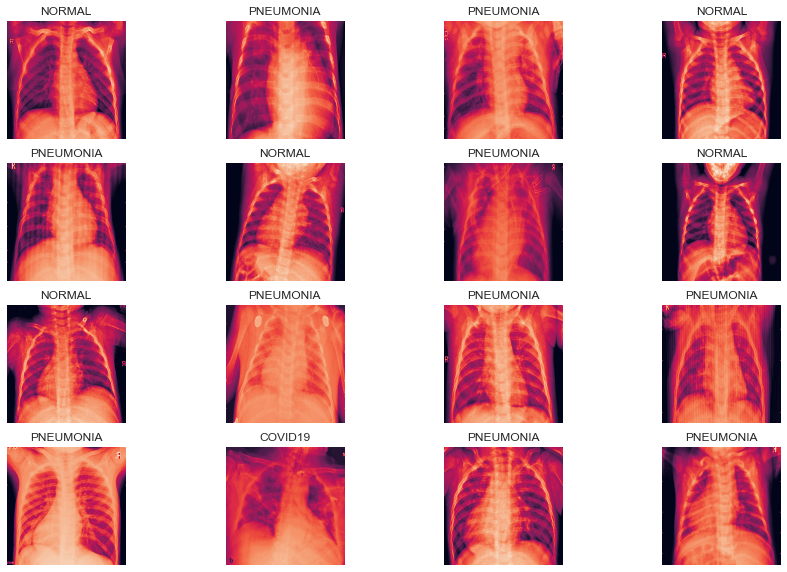

In [11]:
a = train_generator.class_indices

# store class names in a list
class_names = list(a.keys()) 

def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
 
plot_images(x,y)

## 5. Building the model

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# creating the model
model= Sequential()

model.add(Conv2D(filters=128,strides= 1, kernel_size = (5,5), activation='relu', input_shape=(224,224,1,)))
model.add(MaxPool2D(3,3))
model.add(Conv2D(filters=64,kernel_size = (5,5),activation='relu'))
model.add(MaxPool2D(3,3))

model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(2048,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dropout(.1))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(.1))
model.add(Dense(32,activation='relu'))
model.add(Dense(4,activation = 'softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 30)        17310     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 30)       0

In [13]:
# hyperparameters
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# stop the training when there is no improvement after 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
# fit the model
history = model.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=valid_generator,verbose= 1,
          validation_steps=STEP_SIZE_VALID,
          epochs=15, callbacks=early_stop)

Epoch 1/15
197/197 [==============================] - 777s 4s/step - loss: 0.7066 - accuracy: 0.7234 - val_loss: 1.0433 - val_accuracy: 0.5312
Epoch 2/15
197/197 [==============================] - 651s 3s/step - loss: 0.3648 - accuracy: 0.8615 - val_loss: 0.4377 - val_accuracy: 0.8750
Epoch 3/15
197/197 [==============================] - 648s 3s/step - loss: 0.2893 - accuracy: 0.8966 - val_loss: 0.7522 - val_accuracy: 0.6562
Epoch 4/15
197/197 [==============================] - 647s 3s/step - loss: 0.2270 - accuracy: 0.9180 - val_loss: 0.4103 - val_accuracy: 0.8125
Epoch 5/15
197/197 [==============================] - 647s 3s/step - loss: 0.1957 - accuracy: 0.9282 - val_loss: 0.2963 - val_accuracy: 0.8750
Epoch 6/15
197/197 [==============================] - 646s 3s/step - loss: 0.1768 - accuracy: 0.9401 - val_loss: 0.4612 - val_accuracy: 0.7812
Epoch 7/15
197/197 [==============================] - 643s 3s/step - loss: 0.1742 - accuracy: 0.9409 - val_loss: 0.5889 - val_accuracy: 0.6875

In [15]:
# evaluate the model
model.evaluate(valid_generator,steps = STEP_SIZE_VALID)

1/1 [==============================] - 1s 1s/step - loss: 0.2350 - accuracy: 0.9062


[0.23499077558517456, 0.90625]

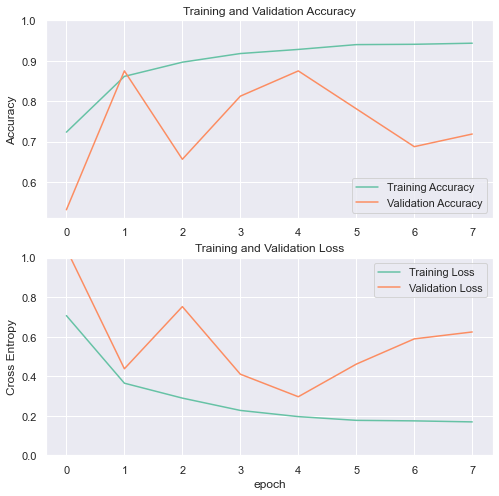

In [16]:
# plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()